In [1]:
import pandas as pd
import scanpy as sc
import anndata as ad
import os
import numpy as np

In [2]:
data_dir = '/home/jing/Phd_project/project_UCD_blca/blca_DATA/blca_DATA_GSE135337/'
os.chdir(data_dir)

In [3]:
names_list = ["GSM4006644_BC1", "GSM4006647_BC4" ,"GSM4006648_BC5", "GSM4751267_BC6" ,"GSM4751268_BC7"]

GSM4006644_BC1


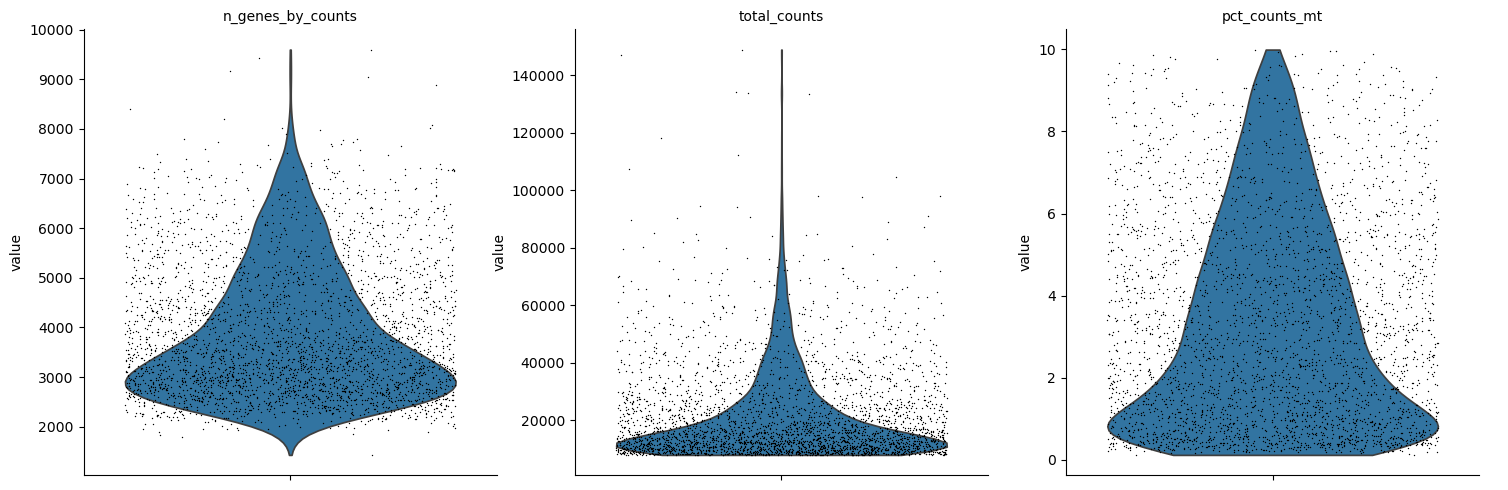

/tmp/ipykernel_34005/2088865276.py:35: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['source'] = name


GSM4006647_BC4


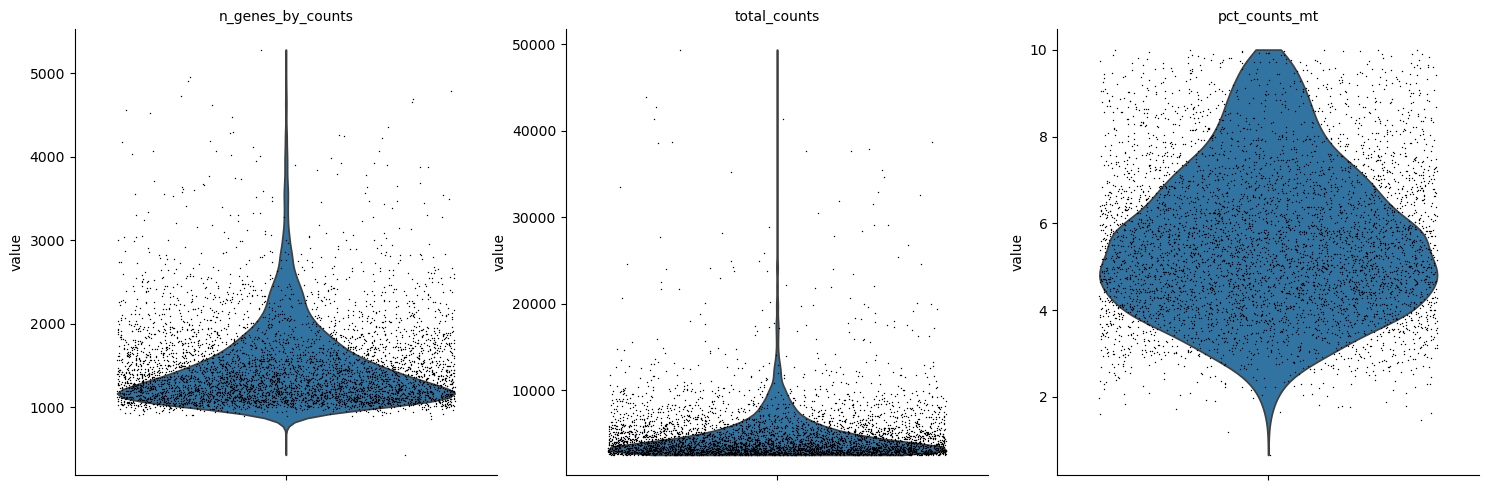

/tmp/ipykernel_34005/2088865276.py:35: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['source'] = name


GSM4006648_BC5


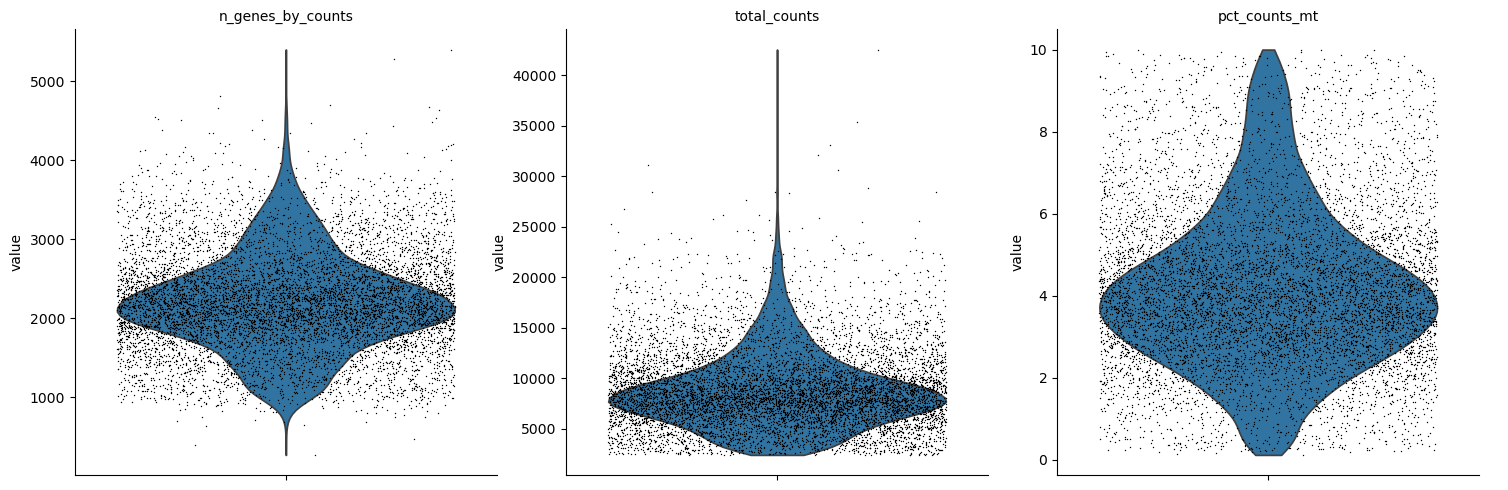

/tmp/ipykernel_34005/2088865276.py:35: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['source'] = name


GSM4751267_BC6


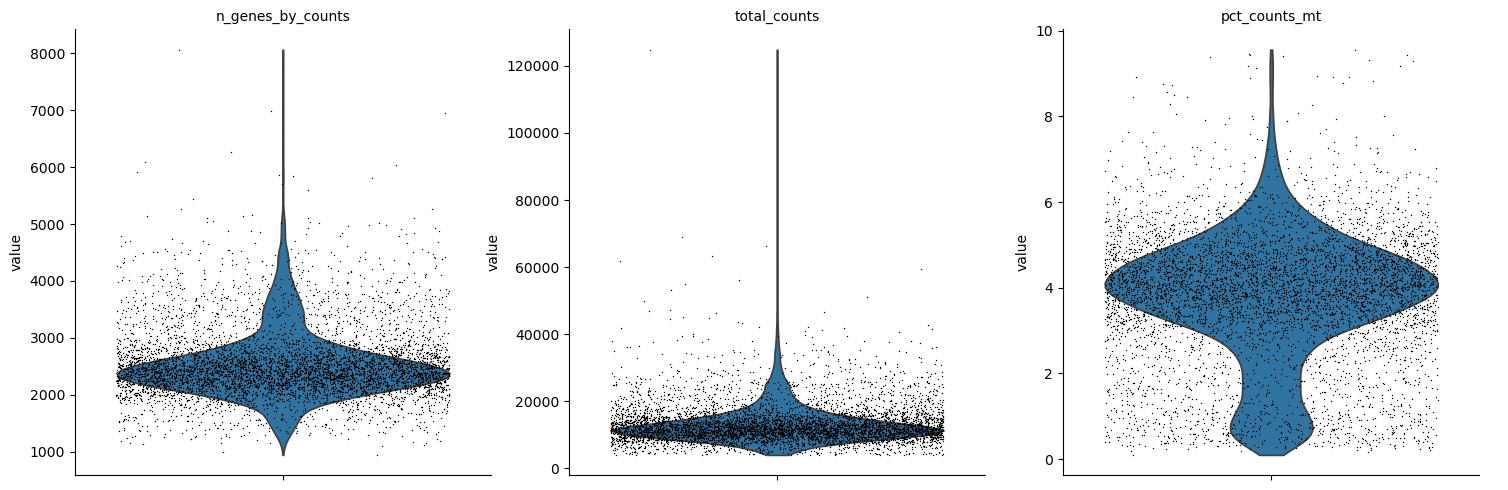

/tmp/ipykernel_34005/2088865276.py:35: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['source'] = name


GSM4751268_BC7


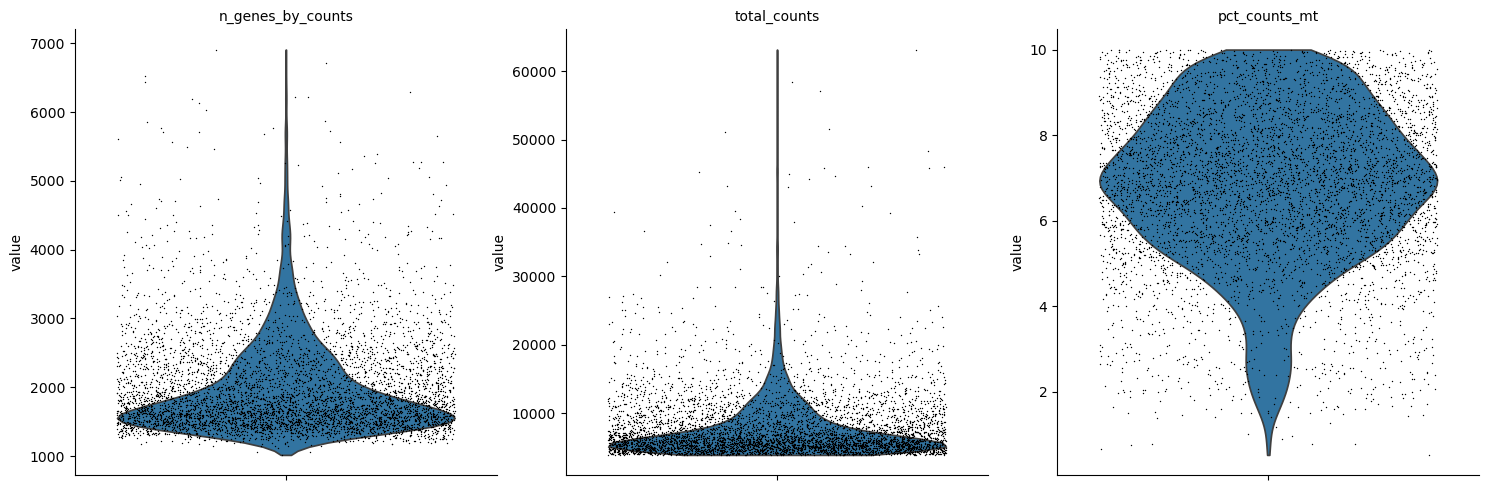

/tmp/ipykernel_34005/2088865276.py:35: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['source'] = name


In [4]:
adata_list = []

# Loop over each sample and read in the AnnData object
for name in names_list:
    file_path = f"{name}_gene_cell_exprs_table.txt.gz"
    df = pd.read_csv(file_path, sep='\t')
    df.index = df.iloc[:, 0]
    gene_symbols = df.iloc[:,:2]

    # Drop the first two columns (Ensembl ID and gene name)
    df = df.iloc[:, 2:]
    # Transpose so that cells are rows and genes are columns
    df = df.T

    adata = ad.AnnData(df)

    adata.obs['CellID']= df.index
    adata.var[['Ensemble_ID','Gene']]= gene_symbols
    adata.var.index= adata.var['Gene']
    adata.var_names_make_unique() 
    adata.var['mt'] =adata.var_names.str.startswith('MT-')

    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.calculate_qc_metrics(adata,qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    print(name)
    sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True)
    
    adata= adata[adata.obs.n_genes_by_counts <6001, :]
    #adata= adata[adata.obs.pct_counts_mt< 5, :].copy()

    adata.obs['source'] = name
    adata.layers["counts"] = adata.X.copy()    

    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata.raw = adata  # keep full dimension safe
    adata_list.append(adata)
    

In [5]:
batch_names = [adata.obs['source'].iloc[0] for adata in adata_list]
adata = adata_list[0].concatenate(adata_list[1:], batch_key='source', batch_categories=batch_names)       

/tmp/ipykernel_34005/1630503105.py:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata_list[0].concatenate(adata_list[1:], batch_key='source', batch_categories=batch_names)


In [6]:
immune_remove = pd.read_pickle('/home/jing/Phd_project/project_UCD_blca/blca_publication_OUTPUT/immune_cells_obs.pkl')
adata_non_immune = adata[~adata.obs.index.isin(immune_remove.index),]
adata_non_immune

View of AnnData object with n_obs × n_vars = 27864 × 13656
    obs: 'CellID', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'source'
    var: 'mt', 'Ensemble_ID-GSM4006644_BC1', 'Gene-GSM4006644_BC1', 'n_cells_by_counts-GSM4006644_BC1', 'mean_counts-GSM4006644_BC1', 'pct_dropout_by_counts-GSM4006644_BC1', 'total_counts-GSM4006644_BC1', 'Ensemble_ID-GSM4006647_BC4', 'Gene-GSM4006647_BC4', 'n_cells_by_counts-GSM4006647_BC4', 'mean_counts-GSM4006647_BC4', 'pct_dropout_by_counts-GSM4006647_BC4', 'total_counts-GSM4006647_BC4', 'Ensemble_ID-GSM4006648_BC5', 'Gene-GSM4006648_BC5', 'n_cells_by_counts-GSM4006648_BC5', 'mean_counts-GSM4006648_BC5', 'pct_dropout_by_counts-GSM4006648_BC5', 'total_counts-GSM4006648_BC5', 'Ensemble_ID-GSM4751267_BC6', 'Gene-GSM4751267_BC6', 'n_cells_by_counts-GSM4751267_BC6', 'mean_counts-GSM4751267_BC6', 'pct_dropout_by_counts-GSM4751267_BC6', 'total_counts-GSM4751267_BC6', 'Ensemble_ID-GSM4751268_BC7', 'Gene-GSM4751268_BC7', '

In [7]:
adata_non_immune.raw = adata_non_immune  # keep full dimension safe
sc.pp.highly_variable_genes(
    adata_non_immune,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="counts",
    batch_key="source",
    subset=True,
)

In [8]:
adata_non_immune

AnnData object with n_obs × n_vars = 27864 × 2000
    obs: 'CellID', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'source'
    var: 'mt', 'Ensemble_ID-GSM4006644_BC1', 'Gene-GSM4006644_BC1', 'n_cells_by_counts-GSM4006644_BC1', 'mean_counts-GSM4006644_BC1', 'pct_dropout_by_counts-GSM4006644_BC1', 'total_counts-GSM4006644_BC1', 'Ensemble_ID-GSM4006647_BC4', 'Gene-GSM4006647_BC4', 'n_cells_by_counts-GSM4006647_BC4', 'mean_counts-GSM4006647_BC4', 'pct_dropout_by_counts-GSM4006647_BC4', 'total_counts-GSM4006647_BC4', 'Ensemble_ID-GSM4006648_BC5', 'Gene-GSM4006648_BC5', 'n_cells_by_counts-GSM4006648_BC5', 'mean_counts-GSM4006648_BC5', 'pct_dropout_by_counts-GSM4006648_BC5', 'total_counts-GSM4006648_BC5', 'Ensemble_ID-GSM4751267_BC6', 'Gene-GSM4751267_BC6', 'n_cells_by_counts-GSM4751267_BC6', 'mean_counts-GSM4751267_BC6', 'pct_dropout_by_counts-GSM4751267_BC6', 'total_counts-GSM4751267_BC6', 'Ensemble_ID-GSM4751268_BC7', 'Gene-GSM4751268_BC7', 'n_cells_b

In [9]:
import scvi
scvi.model.SCVI.setup_anndata(adata_non_immune, layer="counts", batch_key="source")

In [10]:
model = scvi.model.SCVI(adata_non_immune, n_layers=2, n_latent=30, gene_likelihood="nb")

In [11]:
model.train()

/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/jing/miniforge3/envs/cstar/lib/python3.12/site ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/jing/miniforge3/envs/cstar/lib/python3.12/site ...
/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bo

Training:   0%|          | 0/287 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=287` reached.


In [12]:
SCVI_LATENT_KEY = "X_scVI"
adata_non_immune.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

In [13]:
sc.pp.neighbors(adata_non_immune, use_rep=SCVI_LATENT_KEY)


In [14]:
sc.tl.leiden(adata_non_immune,resolution=1,random_state=0)

/tmp/ipykernel_34005/3475989442.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_non_immune,resolution=1,random_state=0)


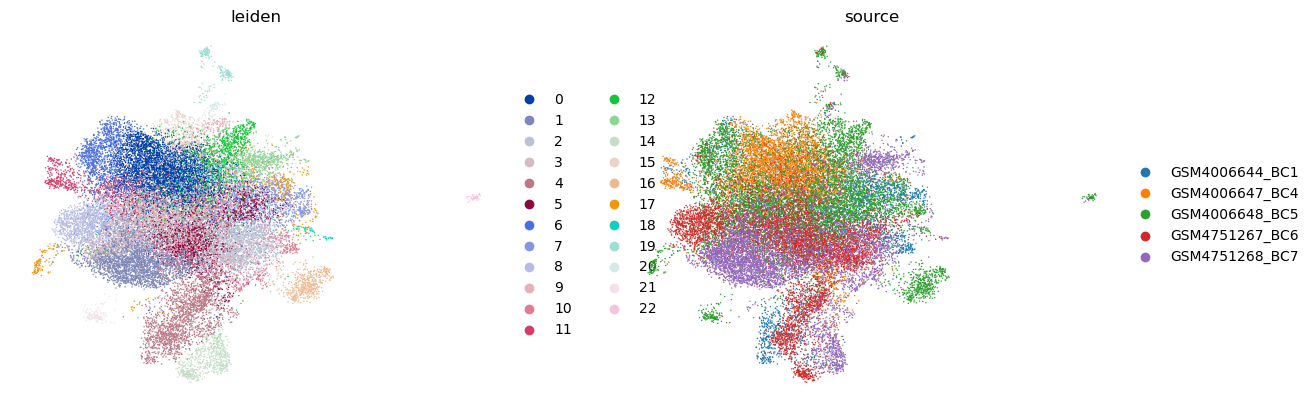

In [15]:
sc.tl.umap(adata_non_immune)#, min_dist=0.5)
sc.pl.umap(
    adata_non_immune,
    color=[ "leiden","source",],
    frameon=False,
    ncols=2
)

In [16]:
###Breakdown of cells counts per cluster
pd.crosstab(adata_non_immune.obs['source'],adata_non_immune.obs['leiden'])

leiden,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
source,,,,,,,,,,,,,,,,,,,,,
GSM4006644_BC1,150,40,114,66,489,62,224,656,14,64,...,71,68,27,11,71,22,0,9,5,0
GSM4006647_BC4,2926,38,15,25,51,160,227,21,7,9,...,41,29,512,2,62,212,1,62,0,0
GSM4006648_BC5,377,434,329,916,144,762,983,727,287,1109,...,110,10,57,468,202,81,156,40,116,44
GSM4751267_BC6,183,312,1248,619,1019,684,81,67,1046,50,...,90,201,37,0,13,21,10,9,2,1
GSM4751268_BC7,152,2042,555,629,279,147,7,17,56,3,...,538,363,4,3,73,22,22,35,0,7


In [17]:
adata_non_immune.obs

,CellID,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,source,_scvi_batch,_scvi_labels,leiden
AAACCTGAGAAGAAGC.1-GSM4006644_BC1,AAACCTGAGAAGAAGC.1,5037,5037,29207,1799,6.159482,GSM4006644_BC1,0,0,10
AAACCTGAGCTACCTA.1-GSM4006644_BC1,AAACCTGAGCTACCTA.1,2769,2769,12115,392,3.235658,GSM4006644_BC1,0,0,4
AAACCTGCACGGCGTT.1-GSM4006644_BC1,AAACCTGCACGGCGTT.1,4385,4385,23784,1480,6.222671,GSM4006644_BC1,0,0,10
AAACCTGCATCTCGCT.1-GSM4006644_BC1,AAACCTGCATCTCGCT.1,4337,4337,17372,248,1.427585,GSM4006644_BC1,0,0,14
AAACCTGTCAGGCCCA.1-GSM4006644_BC1,AAACCTGTCAGGCCCA.1,3700,3700,19616,368,1.876020,GSM4006644_BC1,0,0,7
...,...,...,...,...,...,...,...,...,...,...
TTTGTCAGTACAGACG.1-GSM4751268_BC7,TTTGTCAGTACAGACG.1,1859,1859,6857,475,6.927228,GSM4751268_BC7,4,0,1
TTTGTCAGTCTAGTCA.1-GSM4751268_BC7,TTTGTCAGTCTAGTCA.1,1420,1420,4543,333,7.329958,GSM4751268_BC7,4,0,0
TTTGTCAGTGGCCCTA.1-GSM4751268_BC7,TTTGTCAGTGGCCCTA.1,4206,4206,21459,1849,8.616431,GSM4751268_BC7,4,0,10
TTTGTCAGTTCTGGTA.1-GSM4751268_BC7,TTTGTCAGTTCTGGTA.1,2581,2581,10731,909,8.470786,GSM4751268_BC7,4,0,0


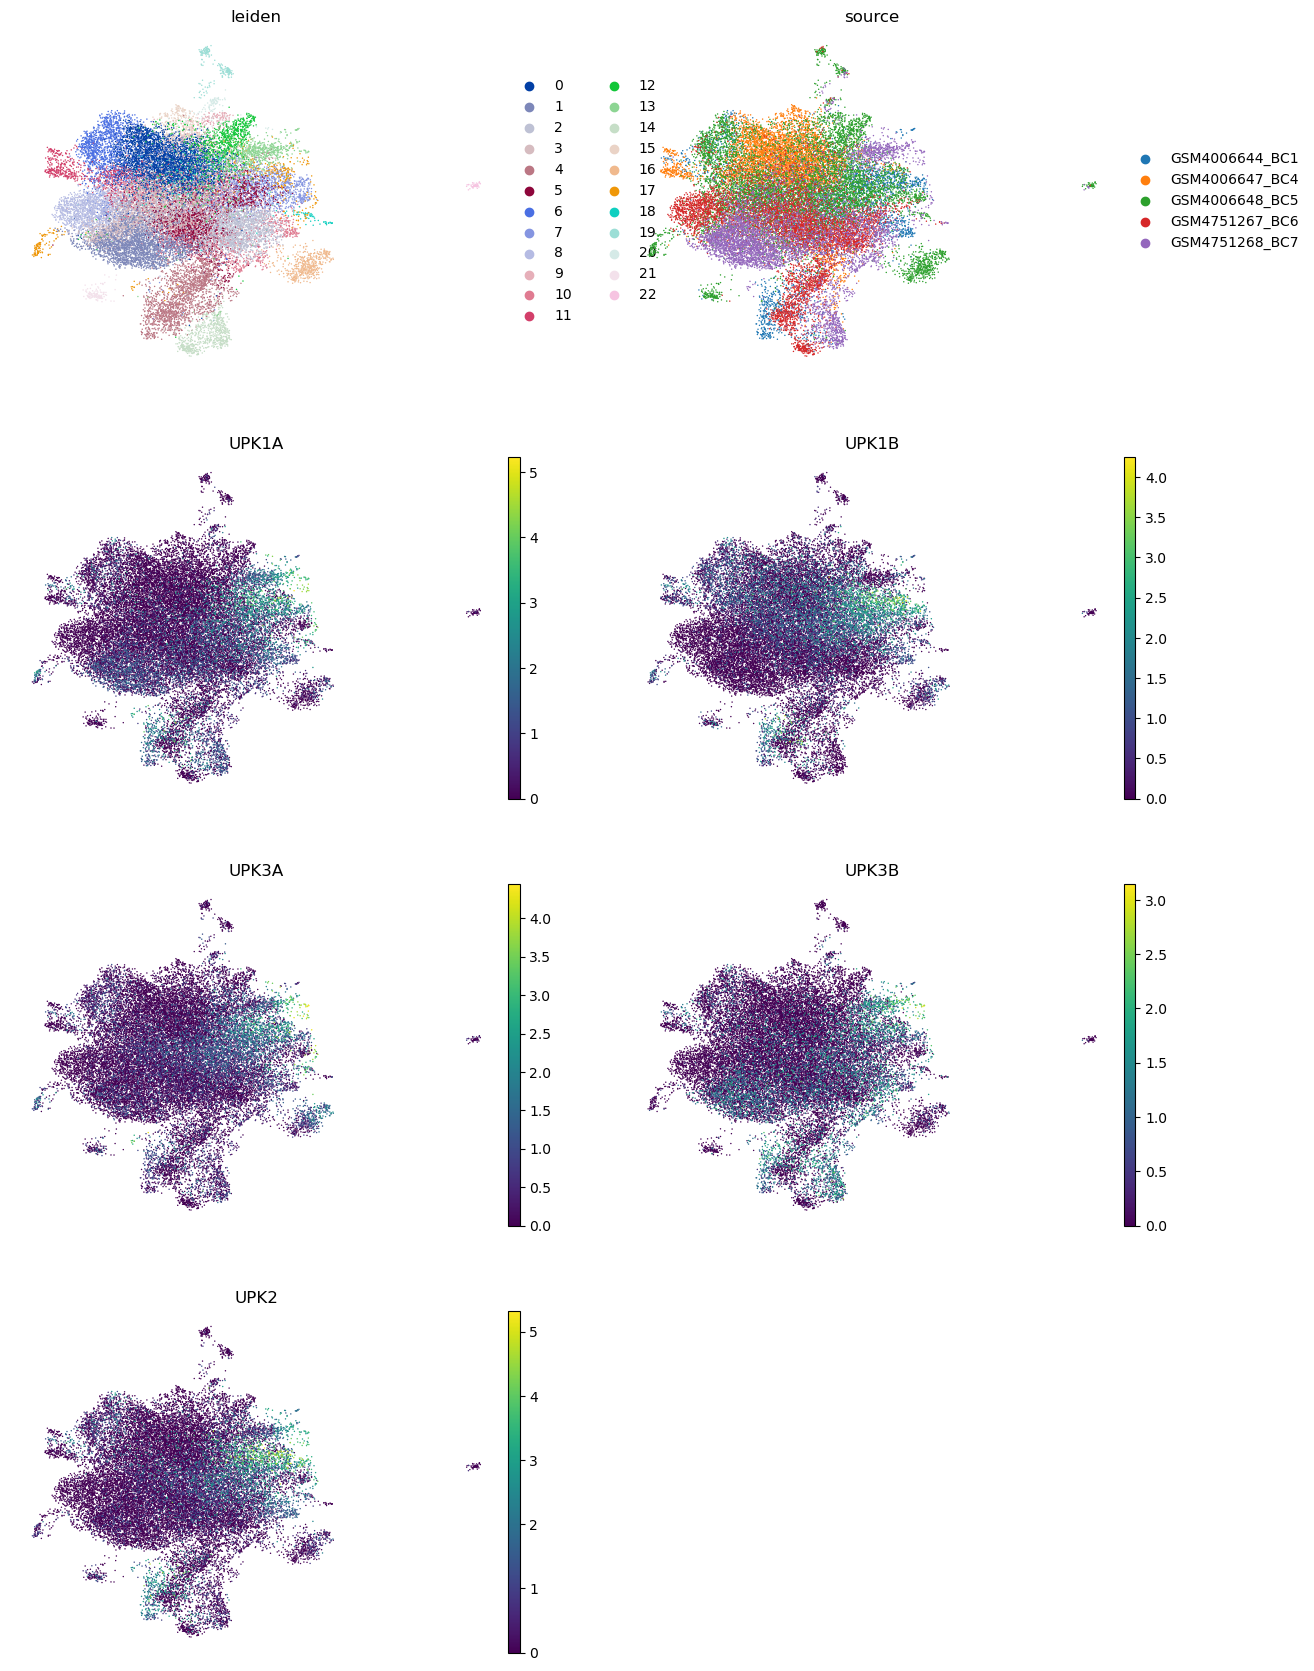

In [18]:
sc.pl.umap(
    adata_non_immune,
    color=[ "leiden","source",'UPK1A','UPK1B','UPK3A','UPK3B','UPK2'],
    frameon=False,
    ncols=2,
)

In [19]:
obs= pd.read_csv('/home/jing/Phd_project/project_UCD_blca/blca_publication_OUTPUT/non_immune_cells_obs.csv',index_col=0)
obs

,CellID,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,source,_scvi_batch,_scvi_labels,leiden,Stage
AAACCTGAGAAGAAGC.1-GSM4006644_BC1,AAACCTGAGAAGAAGC.1,5037,5037,29207,1799,6.159482,GSM4006644_BC1,0,0,5,Ta
AAACCTGAGCTACCTA.1-GSM4006644_BC1,AAACCTGAGCTACCTA.1,2769,2769,12115,392,3.235658,GSM4006644_BC1,0,0,2,Ta
AAACCTGCACGGCGTT.1-GSM4006644_BC1,AAACCTGCACGGCGTT.1,4385,4385,23784,1480,6.222671,GSM4006644_BC1,0,0,2,Ta
AAACCTGCATCTCGCT.1-GSM4006644_BC1,AAACCTGCATCTCGCT.1,4337,4337,17372,248,1.427585,GSM4006644_BC1,0,0,4,Ta
AAACCTGTCAGGCCCA.1-GSM4006644_BC1,AAACCTGTCAGGCCCA.1,3700,3700,19616,368,1.876020,GSM4006644_BC1,0,0,1,Ta
...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAGTACAGACG.1-GSM4751268_BC7,TTTGTCAGTACAGACG.1,1859,1859,6857,475,6.927228,GSM4751268_BC7,4,0,0,Ta
TTTGTCAGTCTAGTCA.1-GSM4751268_BC7,TTTGTCAGTCTAGTCA.1,1420,1420,4543,333,7.329958,GSM4751268_BC7,4,0,0,Ta
TTTGTCAGTGGCCCTA.1-GSM4751268_BC7,TTTGTCAGTGGCCCTA.1,4206,4206,21459,1849,8.616431,GSM4751268_BC7,4,0,2,Ta
TTTGTCAGTTCTGGTA.1-GSM4751268_BC7,TTTGTCAGTTCTGGTA.1,2581,2581,10731,909,8.470786,GSM4751268_BC7,4,0,1,Ta
